In [1]:
from CartPole import CartPole, _remap_angle, remap_angle, _loss, loss
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
import matplotlib.tri as tri
from scipy.optimize import minimize

In [2]:
## main functions to define nonlinear model definitions
## MAIN FUNCTIONS TO DEFINE NONLINEAR MODEL DEFINITIONS. COPIED FROM TASK_2_PARTS_1_AND_2

# function to return array of X,Y datapoints: list of typles (X, Y) where X and Y are numpy arrays of length 4
# Y currently set to the difference between new state and initial state
# if want_actions is True, datapoints generated will be of form (X, Y) where X is a numpy array of length 5 and Y is a numpy array of length 4
def make_array_of_XY_datapoints(num_datapoints, want_actions=False):

    # initialise instance of CartPole
    pendulum = CartPole()

    # create empty list into which (X,Y) datapoints will go
    datapoints = []

    # fill with num_datapoints number of (X,Y) datapoints
    for i in range(num_datapoints):
            
        # initialise random state
        cart_location = np.random.uniform(-9, 9)
        cart_velocity = np.random.uniform(-10, 10)
        pole_angle = np.random.uniform(-np.pi, np.pi)
        pole_velocity = np.random.uniform(-15, 15)
        action = np.random.uniform(-4, 4)
        X = np.array([cart_location, cart_velocity, pole_angle, pole_velocity])
        X_with_action = np.array([cart_location, cart_velocity, pole_angle, pole_velocity, action])

        ## update state and run one iteration to get new state and Y

        # if dont want actions
        if want_actions == False:
            pendulum.setState(X)
            pendulum.performAction()
            new_state = pendulum.getState()
            Y = new_state - X
        
        # if want actions
        else:
            pendulum.setState(X_with_action[:4])
            pendulum.performAction(X_with_action[4])
            new_state = pendulum.getState()
            Y = new_state - X_with_action[:4]

        # add X, Y datapoints to array
        if want_actions == True:
            datapoints.append((X_with_action, Y))
        else:
            datapoints.append((X, Y))

    return datapoints

# Kernal function for x, xdot and thetadot     X, X2 and sigma are vectors of length 4; function returns a scalar
# works for X, X2, sigma of length 4 and length 5 (if action is included)
def K(X, X2, sigma):

    exponent = 0

    # iterating over state variables within X, X2
    for j in range(4):

        # for non theta components
        if j != 2:
            exponent += ((X[j] - X2[j])**2) / (2*sigma[j]**2)
        
        # for theta component
        else:
            exponent += (np.sin((X[j]-X2[j]) / 2) ** 2) / (2*sigma[j]**2)
    
    # if action is in X and X2:
    if len(X) == 5 and len(X2) == 5:
        exponent += ((X[4] - X2[4])**2) / (2*sigma[4]**2)
    
    return np.exp((-1) * exponent)

# function to return K_M,N matrix (matrix of dimension MxN) given dimensions M, N and sigma
def get_K_MN_matrix(M, N, sigma, array_of_datapoints):

    # set N actual N irrelevant of what is passed in ##### can i fix this so it isn't needed? might be fine without
    N = len(array_of_datapoints)

    # choose M basis centres from array_of_datapoints
    if len(array_of_datapoints[0][0]) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(array_of_datapoints[0][0]) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MN matrix
    K_MN = np.zeros((M, N))


    # fill K_MN matrix
    for i in range(M):
        for j in range(N):
            K_MN[i, j] = K(array_of_datapoints[j][0], M_basis_centres[i], sigma)
    
    return K_MN

# function to return K_MM matrix
def get_K_MM_matrix(M, sigma):

    # choose M basis centres from array_of_datapoints
    if len(sigma) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(sigma) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MM matrix
    K_MM = np.zeros((M, M))

    # fill K_MM matrix
    for i in range(M):
        for j in range(M):
            K_MM[i, j] = K(M_basis_centres[i], M_basis_centres[j], sigma)

    return K_MM
# function to find alpha vector given K_MM matrix, K_MN matrix lamda, array_of_XY_datapoints and index of state vector
def get_alpha(K_MN, K_MM, lamda, array_of_XY_datapoints, index):

    # get Y vector from array_of_XY_datapoints
    # Y vector is of length N; contains one type of state variable only
    Y = np.zeros(len(array_of_XY_datapoints))
    for i in range(len(array_of_XY_datapoints)):
        Y[i] = array_of_XY_datapoints[i][1][index]

    ## get into form A \alpha = b
    A = np.matmul(K_MN, K_MN.T) + lamda * K_MM
    b = np.matmul(K_MN, Y)

    # solve for alpha; this is the alpha vector of length M corresponding to the state variable at the index=index
    alpha = np.linalg.lstsq(A, b, rcond=None)[0]

    return alpha

# define function to return optimum alpha vectors (train model). Basis vectors are known from sobol sequence
def get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda):

    num_datapoints = len(datapoints)

    # train model to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints)
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

    return alpha_x, alpha_xdot, alpha_theta, alpha_thetadot

# function to get standard deviation of state variables. works for when datapoints contain actions too
def get_std_as_vector(array_of_datapoints):


    # create list of each set of datapoints
    xs, xdots, thetas, thetadots, actions = [], [], [], [], []

    # iterate over array and populate lists of state variables
    for datapoint in array_of_datapoints:
        xs.append(datapoint[0][0])
        xdots.append(datapoint[0][1])
        thetas.append(datapoint[0][2])
        thetadots.append(datapoint[0][3])

        if len(datapoint[0]) == 5: # action is in datapoints too
            actions.append(datapoint[0][4])

    # create standard deviation vector
    if len(array_of_datapoints[0][0]) == 5: # action is in datapoint too
        standard_deviation = [np.std(xs), np.std(xdots), np.std(thetas), np.std(thetadots), np.std(actions)]
    else:
        standard_deviation = [np.std(xs), np.std(xdots), np.std(thetas), np.std(thetadots)]

    return standard_deviation
# function to find Y given X according to nonlinear model, returning Y as a vector
def find_Y_given_X_according_to_nonlinear_model(X, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma):

    # initiate sobol sequence to determine basis centres
    M_basis_centres = sobol_seq.i4_sobol_generate(5, num_basis_centres)  # M_basis_centres is now a matrix of size num_basis_centres x 5; each row is a basis centre

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # find Y
    Y_x, Y_xdot, Y_theta, Y_thetadot = 0, 0, 0, 0
    for i in range(num_basis_centres):
        Y_x += alpha_x[i] * K(X, M_basis_centres[i, :], sigma)
        Y_xdot += alpha_xdot[i] * K(X, M_basis_centres[i, :], sigma)
        Y_theta += alpha_theta[i] * K(X, M_basis_centres[i, :], sigma)
        Y_thetadot += alpha_thetadot[i] * K(X, M_basis_centres[i, :], sigma)
    
    return [Y_x, Y_xdot, Y_theta, Y_thetadot]

In [3]:
# define function to return the total loss function according to real dynamics of trajectory given initial state and number of iterations
def total_loss_according_to_real_dynamics(initial_state, no_its, p):

    # create instance of Cartpole and set initial state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    # initialise loss function value with initial state's loss
    loss_value = pendulum.loss()

    # # set state to initial state
    # state = initial_state

    # iterating over number of iterations except start because already done
    for it in range(no_its-1):

        # run an iteration of simulation with policy as the action
        state = pendulum.getState()
        policy = np.dot(p, state)
        pendulum.performAction(policy) # policy = action

        # add to loss value
        loss_value += pendulum.loss()

    return loss_value

In [15]:
### TASK 2.3: 1D and 2D scans of the policy function coefficients

# define function to generate 1D scans, varying each component of p
def make_1D_scans_varying_p_against_total_loss_using_real_dynamics(initial_state, no_its, no_increments_on_graphs, p_range, p_constant):

    # create ranges of p to scan
    array_of_p_scalars_to_test = np.linspace(-p_range, p_range, no_increments_on_graphs)

    # initialise array to store loss values
    loss_values_when_vary_p1 = np.zeros(no_increments_on_graphs)
    loss_values_when_vary_p2 = np.zeros(no_increments_on_graphs)
    loss_values_when_vary_p3 = np.zeros(no_increments_on_graphs)
    loss_values_when_vary_p4 = np.zeros(no_increments_on_graphs)

    # iterate over each value of p
    for i, p_scalar_to_test in enumerate(array_of_p_scalars_to_test):

        p_vector_to_test = [p_scalar_to_test, p_constant, p_constant, p_constant]
        loss_values_when_vary_p1[i] = total_loss_according_to_real_dynamics(initial_state, no_its, p_vector_to_test)

        p_vector_to_test = [p_constant, p_scalar_to_test, p_constant, p_constant]
        loss_values_when_vary_p2[i] = total_loss_according_to_real_dynamics(initial_state, no_its, p_vector_to_test)

        p_vector_to_test = [p_constant, p_constant, p_scalar_to_test, p_constant]
        loss_values_when_vary_p3[i] = total_loss_according_to_real_dynamics(initial_state, no_its, p_vector_to_test)

        p_vector_to_test = [p_constant, p_constant, p_constant, p_scalar_to_test]
        loss_values_when_vary_p4[i] = total_loss_according_to_real_dynamics(initial_state, no_its, p_vector_to_test)
    
    # plot graphs
    plt.subplot(2, 2, 1)
    plt.plot(array_of_p_scalars_to_test, loss_values_when_vary_p1)
    plt.xlabel('p[0] values')
    plt.ylabel('total loss')
    plt.title('p[0]')

    plt.subplot(2, 2, 2)
    plt.plot(array_of_p_scalars_to_test, loss_values_when_vary_p2)
    plt.xlabel('p[1] values')
    plt.ylabel('total loss')
    plt.title('p[1]')

    plt.subplot(2, 2, 3)
    plt.plot(array_of_p_scalars_to_test, loss_values_when_vary_p3)
    plt.xlabel('p[2] values')
    plt.ylabel('total loss')
    plt.title('p[2]')

    plt.subplot(2, 2, 4)
    plt.plot(array_of_p_scalars_to_test, loss_values_when_vary_p4)
    plt.xlabel('p[3] values')
    plt.ylabel('total loss')
    plt.title('p[3]')

    plt.suptitle('1D scans of the policy function coefficients')
    plt.tight_layout()
    plt.show()

    print(loss_values_when_vary_p1)


# define function to generate 2D scans, varying each pair of components of p
def make_2D_scans_varying_p_against_total_loss_using_real_dynamics(initial_state, no_its, no_increments_on_graphs, p_range, p_constant):

    # create lists of x and y labels and suptitles
    x_labels = ["p[0]", "p[0]", "p[0]", "p[1]", "p[1]", "p[2]"]
    y_labels = ["p[1]", "p[2]", "p[3]", "p[2]", "p[3]", "p[3]"]
    suptitles = ["Scans of p[0] and p[1]", "Scans of p[0] and p[2]", "Scans of p[0] and p[3]", "Scans of p[1] and p[2]", "Scans of p[1] and p[3]", "Scans of p[2] and p[3]"]

    for indexes_of_p_we_scan_over in range(0, 6):

        # initialsie p vector
        p = [p_constant, p_constant, p_constant, p_constant]

        # initilaise emtpy lists into which losses will go
        list_of_losses = []

        # get array of values to test in our scan
        array_of_values_of_variable_to_scan_x = np.linspace(-p_range, p_range, no_increments_on_graphs)
        array_of_values_of_variable_to_scan_y = np.linspace(-p_range, p_range, no_increments_on_graphs)

        # TRY THIS
        array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y = np.meshgrid(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)
        array_of_values_of_variable_to_scan_x_flattened = array_of_values_of_variable_to_scan_x.flatten()
        array_of_values_of_variable_to_scan_y_flattened = array_of_values_of_variable_to_scan_y.flatten()
        triangulation = tri.Triangulation(array_of_values_of_variable_to_scan_x_flattened, array_of_values_of_variable_to_scan_y_flattened)


        # loop over values the variable which is being scanned takes
        for i, (xi, yi) in enumerate(zip(array_of_values_of_variable_to_scan_x_flattened, array_of_values_of_variable_to_scan_y_flattened)):

            # update state vector
            if indexes_of_p_we_scan_over == 0: # scanning over p[0] and p[1]
                p[0] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[1] = array_of_values_of_variable_to_scan_y_flattened[i]
            
            elif indexes_of_p_we_scan_over == 1: # scanning over [p0] and p[2]
                p[0] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[2] = array_of_values_of_variable_to_scan_y_flattened[i]

            
            elif indexes_of_p_we_scan_over == 2: # scanning over p[0] and p[3]
                p[0] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[3] = array_of_values_of_variable_to_scan_y_flattened[i]
            
            elif indexes_of_p_we_scan_over == 3: # scanning over p[1] and p[2]
                p[1] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[2] = array_of_values_of_variable_to_scan_y_flattened[i]
            
            elif indexes_of_p_we_scan_over == 4: # scanning over p[1] and p[3]
                p[1] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[3] = array_of_values_of_variable_to_scan_y_flattened[i]
            
            elif indexes_of_p_we_scan_over == 5: # scanning over p[2] and p[3]
                p[2] = array_of_values_of_variable_to_scan_x_flattened[i]
                p[3] = array_of_values_of_variable_to_scan_y_flattened[i]
            
            else:
                print("error")

            # get and append the loss
            loss = total_loss_according_to_real_dynamics(initial_state, no_its, p)
            list_of_losses.append(loss)


        contour = plt.tricontourf(triangulation, list_of_losses)
        cbar = plt.colorbar(contour)
        plt.xlabel(x_labels[indexes_of_p_we_scan_over])
        plt.ylabel(y_labels[indexes_of_p_we_scan_over])
        plt.title(suptitles[indexes_of_p_we_scan_over])

        print(list_of_losses[0], array_of_values_of_variable_to_scan_x_flattened[0], array_of_values_of_variable_to_scan_y_flattened[0])
        print(list_of_losses[-1], array_of_values_of_variable_to_scan_x_flattened[-1], array_of_values_of_variable_to_scan_y_flattened[-1])
        print(list_of_losses[0], list_of_losses[20], list_of_losses[40], list_of_losses[60], list_of_losses[80])

        plt.show()
        



#initial_state = [0, 1, np.pi, 5] # oscillations about stable equilibrium
initial_state = [0, 0, 0.1, 0] # slight pertubation from unstable equilibrium
no_its = 8 # set as about 8 to 10 as this corresponds to approx. 1 to 2 oscillations when initial_state = [0, 1,  np.pi, 5]
no_increments_on_graphs = 100  # 400 when range is 60, 100 when range 12
p_range = 40 ## what should this be # 60 or 12 for initial_state = [0, 1,  np.pi, 5]
p_constant = 1 ## what should this be



# make_1D_scans_varying_p_against_total_loss_using_real_dynamics(initial_state, no_its, no_increments_on_graphs, p_range, p_constant)

# no_increments_on_graphs = 20
#make_2D_scans_varying_p_against_total_loss_using_real_dynamics(initial_state, no_its, no_increments_on_graphs, p_range, p_constant)


In [9]:
### TASK 2.3 part 2 and 3, optimise the unknowns of p to minimise the loss function using real dynamics

# rewrite total loss function using real dynamics to be used in scipy.optimize.minimize
def total_loss_according_to_real_dynamics_for_scipy(p):
        
    # set initial state and no_its here instead
    initial_state = [5, 1, 0.1, 0.1]
    initial_state = [0, 0, 0.1, 0]

    # initial_state = [0, 0, 0.5, 0]
    # initial_state = [0, 0, 0.3, 0]
    # initial_state = [0, 0, 0.2, 0]
    # initial_state = [0, 0, 0.5, 0.2]
    # initial_state = [0, 1, -0.1, 0.1]
    # initial_state = [-1, 1, 0.3, 0.3]
    # initial_state = [-1, 1, -0.3, -0.3]
    # initial_state = [1, -1, -0.3, -0.3]
    # initial_state = [-1, 1, 0.5, 0.3]
    no_its = 8

    # create instance of Cartpole and set initial state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    # initialise loss function value with initial state's loss
    loss_value = pendulum.loss()

    # find accumulated loss of a simulation. no_its - 1 because already done 'first' iteration
    for it in range(no_its-1):

        # run an iteration of simulation with policy as the action
        state = pendulum.getState()
        policy = np.dot(p, state)
        pendulum.performAction(policy) # policy = action

        # add to loss value
        loss_value += pendulum.loss()

    return loss_value


# trying a variery of initial guesses
def get_optimal_p_using_real_dynamics_trying_various_initial_guesses(num_initial_guesses):

    # try a good variety of initial guesses
    array_of_initial_guesses = sobol_seq.i4_sobol_generate(4, num_initial_guesses) # had dimensions num_initial_guesses x 4

    # shift sequences so that they are scaled and centre 0
    array_of_initial_guesses *= 14
    array_of_initial_guesses -= 14/2

    # initialise list of trials of optimal p
    list_of_potential_ps_and_values = []
    list_of_potential_ps = []
    list_of_potential_values = []

    for initial_guess in array_of_initial_guesses:

        
        result = minimize(total_loss_according_to_real_dynamics_for_scipy, initial_guess, method='Nelder-Mead')
        maybe_optimal_p = result.x
        value_at_this_p = result.fun

        list_of_potential_ps.append(maybe_optimal_p)
        list_of_potential_values.append(value_at_this_p)
        

        list_of_potential_ps_and_values.append((maybe_optimal_p, value_at_this_p))
    
    # get p that corresponds to minimum value of the function
    min_index = list_of_potential_values.index(min(list_of_potential_values))
    optimal_p = list_of_potential_ps[min_index]
    optimal_f = list_of_potential_values[min_index]

    return optimal_p, optimal_f    



optimal_p_vector_using_real_dynamics, value_of_f_at_this_value = get_optimal_p_using_real_dynamics_trying_various_initial_guesses(num_initial_guesses=5) # 5 guesses takes about 20 seconds.
print(optimal_p_vector_using_real_dynamics, value_of_f_at_this_value)

# initial_state = [0, 0, 0.1, 0]:    [ 0.35722218  0.96702944 15.88000691  2.39389367], 1.01 -> sobol seq scaled to 8
# initial_state = [0, 0, 0.1, 0]:    [ 0.35722218  0.96702944 15.88000691  2.39389367], 1.01 -> sobol seq scaled to 14
# initial_state = [0, 0, 0.1, 0]:    [ 0.35722218  0.96702944 15.88000691  2.39389367], 1.01 -> sobol seq scaled to 14
# initial_state = [0, 0, -0.1, 0]: same
# initial_state = [0, 0, -0.1, 0]: but for 16 its instead of 8: [ 0.72520277  1.21039944 16.31946321  2.50239014] #40s
# initial_sttae = [0, 0, 0.5, 0]: s.s = 14, 8 its [-4.94668692 -0.72867936 10.3969827   5.64607802] 7.323617812975489
# initial_state = [0, 0, 0.3, 0]: s.s = 30, 8 its [-4.67893524 -0.61756889  9.90754008  6.58988134] 6.711775490929902
# initial_state = [0, 0, 0.2, 0]: s.s = 14, 8 its [ 0.56540203  1.41098405 17.14571019  2.62796701] 1.7297824773087904
# initial_state = [0, 0, 0.1, 0]: s.s=14, 8 its: [ 0.35722768  0.96705494 15.88002628  2.39390662] 1.0104255381239946 (dk why its different)



# initial_state = [0, 1, -0.1, 0.1]: [ 0.40178351  1.17037985 16.39210383  2.56374199], 3.83
# initial_state = [-1, 1, 0.3, 0.3]: [-5.82425586  0.72374997  3.91703827  3.43455415] 7.596503500312949
# initial_state = [-1, 1, -0.3, -0.3]: [ 4.59894983  8.3566905  25.91970017  5.68656416] 6.32034375161164
# initial_state = [-1, 1, 0.5, 0.3]    [-3.52833527  1.97426333 -0.56476564  1.00978406] 7.990698047969145


#[-6.86162676  1.58627917  9.93229971 -6.53035854] 6.712087535036511


## IF I DO ANY MORE OF THIS BIT, CHANGE THE NUMBER OF INITIAL GUESSES BACK FROM 5 TO 10

[ 0.35717546  0.96708205 15.87998253  2.39392091] 1.0104255381845801


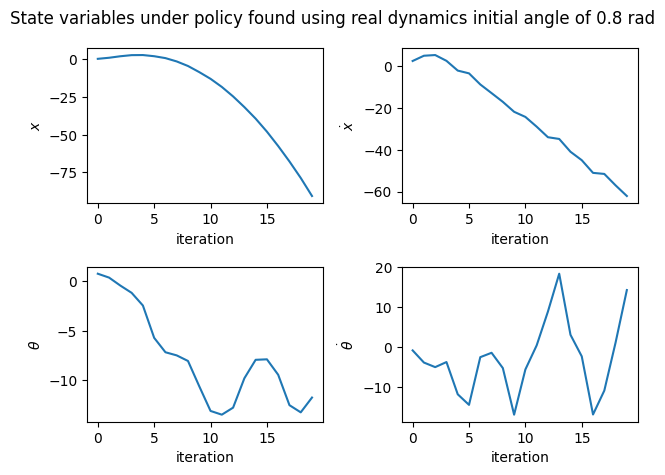

In [15]:
### TASK 2.3 part 4

# function to plot time evolution of variables under policy
def plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, p, no_its):

    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    state = initial_state

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [], [], [], []

    # create list for x axis
    iteration_list = list(range(no_its))

    # run no_its simulations
    for it in range(no_its):
        
        # run one simulation
        policy = np.dot(p, state)
        pendulum.performAction(policy)
        state = pendulum.getState()

        # append state variables to lists to plot
        xs.append(state[0])
        xdots.append(state[1])
        thetas.append(state[2])
        thetadots.append(state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('State variables under policy found using real dynamics initial angle of 0.8 rad')
    plt.tight_layout()
    plt.show()


# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.1, 0], [0.35722218, 0.96702944, 15.88000691, 2.39389367] # set to a value found by optimising
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.5, 0], [-4.94668692, -0.72867936, 10.3969827, 5.64607802] # set to a value found by optimising
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.5, 0], [ 89.59913031, -91.87733874,  10.39602702,  88.56485172]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.3, 0], [-8.0719139,   7.4329858,  10.02962694,  5.3437576 ]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.2, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.3, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.4, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.5, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.6, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.6, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
#initial_state, optimal_p_vector_using_real_dynamics = [0, 0, 0.7, 0], [ 0.56540203,  1.41098405, 17.14571019,  2.62796701]
# optimal_p_vector_using_real_dynamics  = [ 0.35722768,  0.96705494, 15.88002628,  2.39390662] #### THIS ONE BEST, with initial_state = [0, 0, 0.7, 0]
initial_state = [0, 0, 0.8, 0]   

no_its = 20 

plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, optimal_p_vector_using_real_dynamics, no_its)


In [3]:
    # SET THESE ACCORDING TO OPTIMAL VALUES FOUND IN PREVIOUS PART
    num_basis_centres = 250
    lamda = 10 **(-3)
    sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
    datapoints = make_array_of_XY_datapoints(num_datapoints=500, want_actions=True)
    alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda)

In [4]:
### TASK 2.4 

# # SET THESE ACCORDING TO OPTIMAL VALUES FOUND IN PREVIOUS PART
# num_basis_centres = 250
# lamda = 10 **(-3)
# sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
# datapoints = make_array_of_XY_datapoints(num_datapoints=450, want_actions=True)
# alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda)



# define function to return total loss using non-linear model. in form for use with scipy
def total_loss_according_to_non_linear_model(p):
    
    state = [0, 0, 0.7, 0]  # initial state
    no_its = 10 # chosen as nonlinear model is mostly accurate up to this point

    # get loss of first iteration
    pendulum = CartPole()
    pendulum.setState(state)
    loss_value = pendulum.loss()

    # running model simulation and calculating total loss
    for it in range(no_its-1): # no_its-1 becuase first iteration already done

        # get action = policy
        action = np.dot(p, state)
        
        # run one iteration of model simulation to get next state
        state_with_action = list(state)
        state_with_action.append(action)
        Y = find_Y_given_X_according_to_nonlinear_model(state_with_action, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        new_state = np.array(Y) + np.array(state)

        # get and add loss
        pendulum.setState(new_state)
        loss_value += pendulum.loss()

        # set variable state for next iteration
        state = new_state
    
    return loss_value



# ################### TRY THIS TO SPEED IT UP
# def termination_criterion(xk, xk_previous):
#     # Define the termination criterion based on the change in objective function value
#     return abs(total_loss_according_to_non_linear_model(xk) - total_loss_according_to_non_linear_model(xk_previous)) < 0.01




# trying a variery of initial guesses
def get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses):

    # try a good variety of initial guesses
    array_of_initial_guesses = sobol_seq.i4_sobol_generate(4, num_initial_guesses) # had dimensions num_initial_guesses x 4

    # shift sequences so that they are scaled and centre 0
    array_of_initial_guesses *= 14
    array_of_initial_guesses -= 14/2

    # initialise list of trials of optimal p
    list_of_potential_ps_and_values = []
    list_of_potential_ps = []
    list_of_potential_values = []

    
    array_of_initial_guesses = np.array([[0.357, 0.967, 15.9, 2.39]]) # use optimum found in previous part as the initial guesses

    for initial_guess in array_of_initial_guesses:

        result = minimize(total_loss_according_to_non_linear_model, initial_guess, method='Nelder-Mead', tol=0.01)
        print("done one of the initial guesses")
        maybe_optimal_p = result.x
        value_at_this_p = result.fun

        print("before passing through opt alg", initial_guess, total_loss_according_to_non_linear_model(initial_guess))
        print("after passing through optimizatin alg", maybe_optimal_p, value_at_this_p)

        list_of_potential_ps.append(maybe_optimal_p)
        list_of_potential_values.append(value_at_this_p)
        

        list_of_potential_ps_and_values.append((maybe_optimal_p, value_at_this_p))
    
    # get p that corresponds to minimum value of the function
    min_index = list_of_potential_values.index(min(list_of_potential_values))
    optimal_p = list_of_potential_ps[min_index]

    return optimal_p   


## set parameters of nonlinear model in optimizing function for scipy
optimal_p_using_nonlinear_model = get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses=10)

print(optimal_p_using_nonlinear_model)





## ADJUST NO_ITS; SEE IN DESCRIPTION


# initial guess: 0, 0, 0.1, 0     [ 3.93530373  3.59591513 19.34417334  3.65781168] 1.1861822079710374
# initial guess: 0, 0, 0.1, 0     [-7.13811055 -5.18805566 19.45973994  6.21396981] 1.842064585908206


# initial guess: 0.6: 





done one of the initial guesses
before passing through opt alg [ 0.357  0.967 15.9    2.39 ] 9.624538731039836
after passing through optimizatin alg [ 0.36835999  1.05250496 15.26442638  2.30786796] 9.330806116242755
[ 0.36835999  1.05250496 15.26442638  2.30786796]


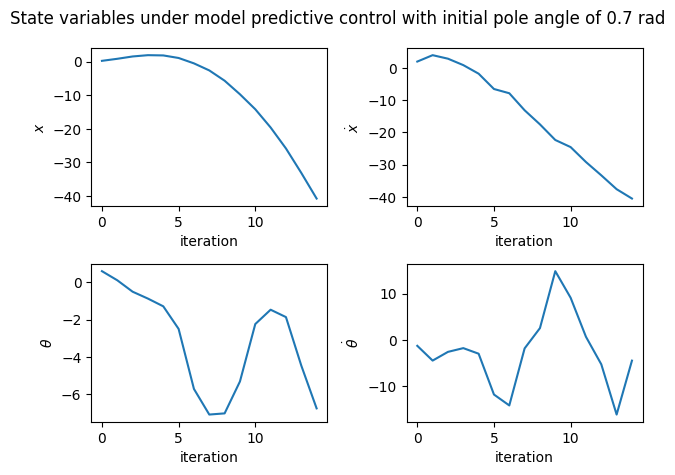

In [8]:




# function to plot time evolution of variables under policy
def plot_time_evolution_of_state_variables_using_nonlinear_model_under_policy(initial_state, p, no_its):

    pendulum = CartPole()

    state = initial_state
    pendulum.setState(state)

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [], [], [], []

    # create list for x axis
    iteration_list = list(range(no_its))

    # run no_its simulations
    for it in range(no_its):
        
        # # run one simulation
        # policy = np.dot(p, state)
        # state = np.append(state, policy) # set fifth component of state to be the action so that its ready to be passed into the following function
        # Y = find_Y_given_X_according_to_nonlinear_model(state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        # state = np.array(Y) + np.array(state[:4])

        policy = np.dot(p, state)
        pendulum.performAction(policy)
        state = pendulum.getState()
        
        # append state variables to lists to plot
        xs.append(state[0])
        xdots.append(state[1])
        thetas.append(state[2])
        thetadots.append(state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('Time evolution of state variables under policy')
    plt.suptitle("State variables under model predictive control with initial pole angle of 0.7 rad")
    plt.tight_layout()
    plt.show()



# can do initial state = 0, 0, 0.2, 0  with 3.93530373,  3.59591513, 19.34417334,  3.65781168

initial_state = [0, 0, 0.7, 0]
#optimal_p_using_nonlinear_model = np.array([0.357, 0.967, 15.9, 2.39]) # can do 0.65
#optimal_p_using_nonlinear_model = np.array([0.508,  0.98, 15.8, 2.82])
#optimal_p_using_nonlinear_model = np.array([0.03902174,  3.05209563, 19.36444122,  3.31414481]) 

#optimal_p_using_nonlinear_model = np.array([-0.03449559,  2.30416467, 19.50710911,  3.39310582]) 

#optimal_p_using_nonlinear_model = np.array([0.37968,     1.00633046, 11.48920486,  2.69490454]) 


# optimal_p_using_nonlinear_model = np.array([ 0.09130193,  1.53767747, 21.94484407,  3.09584656])




#(0.55780912,  2.38047672, 15.8100145,  2.82035052)


plot_time_evolution_of_state_variables_using_nonlinear_model_under_policy(initial_state, optimal_p_using_nonlinear_model, no_its=15)